1) I used the wikipedia arcticle about 'Language'.

In [5]:
import re
from string import punctuation
from operator import itemgetter

# Define a translation table to remove punctuation
translator = str.maketrans('', '', punctuation)

def reading_word_counter(lines):
  wdict = {}
  with open('Life_On_The_Mississippi.txt', 'r', encoding='utf-8') as L:
    line = L.readline()
    nlines = 1
    while line:
      # Remove Byte-Order Mark (BOM) if present
      line = line.lstrip('\ufeff')

      # Remove non-ASCII characters
      line = re.sub(r'[^\x00-\x7F]', '', line)

      # Remove punctuation
      line = line.translate(translator)

      # Split the line into words
      words = line.split()
      for word in words:
        # Remove punctuation and numbers and convert to lowercase
        word = word.lower()
        if word:
          wdict[word] = wdict.get(word, 0) + 1
      line = L.readline()
      nlines += 1
  return wdict

# Read text from a file
with open('Life_On_The_Mississippi.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
# Count word frequency
wdict = reading_word_counter(lines)

# Number of words in the article
print("Total number of words in the vocabulary:", len(wdict))

Total number of words in the vocabulary: 14462


In [6]:
# Sort by frequency in descending order
sorted_wdict = sorted(wdict.items(), key=itemgetter(1), reverse=True)

# Top 100 most frequent words
print("Top 100 most frequent words:")
for word, count in sorted_wdict[:100]:
    print(f"{word}: {count}")

Top 100 most frequent words:
the: 9255
and: 5892
of: 4532
a: 4053
to: 3592
in: 2593
it: 2293
i: 2205
was: 2093
that: 1724
he: 1402
is: 1148
for: 1095
with: 1081
you: 1033
his: 961
had: 961
but: 952
on: 947
as: 881
this: 781
they: 758
at: 750
not: 722
all: 720
by: 713
one: 686
there: 627
were: 625
be: 617
my: 582
or: 581
from: 577
have: 571
out: 541
so: 536
up: 529
him: 523
we: 519
me: 516
when: 505
would: 478
which: 476
river: 457
an: 440
them: 425
no: 422
then: 405
said: 399
are: 387
if: 381
their: 378
now: 369
about: 346
time: 337
been: 335
down: 328
its: 323
could: 313
has: 305
will: 301
into: 300
what: 285
her: 278
two: 273
do: 271
other: 270
some: 269
man: 260
new: 259
any: 238
got: 234
these: 233
she: 233
who: 229
more: 226
water: 222
did: 214
before: 208
over: 202
way: 202
hundred: 200
upon: 200
here: 199
after: 195
day: 193
than: 192
well: 191
through: 191
get: 190
old: 186
every: 186
can: 185
boat: 184
went: 183
never: 182
good: 181
years: 181
see: 176
know: 175


In [15]:
total_word_occurrences = sum(count for word, count in sorted_wdict)

# Calculate the cumulative sum of word occurrences
cumulative_sum = 0
num_distinct_words = 0
for word, count in sorted_wdict:
    cumulative_sum += count
    num_distinct_words += 1
    # Stop when the cumulative sum reaches 90% of the total word occurrences
    if cumulative_sum >= 0.9 * total_word_occurrences:
        break
print(f"There are {total_word_occurrences} non-distinct words in the text and {len(wdict)} distinct words.")
print(f"90% of the non-distinct words are reached with the most frequent {num_distinct_words} distinct words, which are {num_distinct_words/len(wdict)*100:.2f}% of all distinct words")


There are 147420 non-distinct words in the text and 14462 distinct words.
90% of the non-distinct words are reached with the most frequent 3732 distinct words, which are 25.81% of all distinct words


2) Zooming into projection

In [ ]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [100, 60]

# Load BERT.
model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking')
# Set the model to eval mode.
model.eval()
# This notebook assumes CPU execution. If you want to use GPUs, put the model on cuda and modify subsequent code blocks.
#model.to('cuda')
# Load tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')

# Save the BERT vocabulary to a file -- by default it will name this file "vocab.txt".
tokenizer.save_vocabulary(save_directory='.')

print(model.config.vocab_size) # Size of the vocabulary

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

30522


In [ ]:
# Get BERT's vocabulary embeddings.
wordembs = model.get_input_embeddings()

# Convert the vocabulary embeddings to numpy.
allinds = np.arange(0,model.config.vocab_size,1)
inputinds = torch.LongTensor(allinds)
bertwordembs = wordembs(inputinds).detach().numpy()
print(bertwordembs.shape)

(30522, 1024)


In [ ]:
# Read in the vocabulary
filename = "vocab.txt"
with open(filename,'r') as f:
    bertwords = np.array([])
    for line in f:
        bertwords = np.append(bertwords, line.rstrip())

# Determine vocabulary to use for t-SNE/visualization. The indices are hard-coded based partially on inspection:
bert_char_indices_to_use = np.arange(999, 1063, 1)
bert_voc_indices_to_plot = np.append(bert_char_indices_to_use, np.arange(1996, 5932, 1))
bert_voc_indices_to_use = np.append(bert_char_indices_to_use, np.arange(1996, 11932, 1))

bert_voc_indices_to_use_tensor = torch.LongTensor(bert_voc_indices_to_use)
bert_word_embs_to_use = wordembs(bert_voc_indices_to_use_tensor).detach().numpy()
bert_words_to_plot = bertwords[bert_voc_indices_to_plot]


print(len(bert_voc_indices_to_plot))
print(len(bert_voc_indices_to_use))

4000
10000


In [ ]:
# Run t-SNE on the BERT vocabulary embeddings we selected:
mytsne_words = TSNE(n_components=2,early_exaggeration=12,verbose=2,metric='cosine',init='pca',n_iter=2500)
bert_word_embs_to_use_tsne = mytsne_words.fit_transform(bert_word_embs_to_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 5.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.267747
[t-SNE] Computed conditional probabilities in 0.802s
[t-SNE] Iteration 50: error = 97.8644180, gradient norm = 0.0074058 (50 iterations in 15.231s)
[t-SNE] I

In [ ]:
# Plot the whole transformed BERT vocabulary embeddings:
fig = plt.figure()
alltexts = list()
for i, txt in enumerate(bert_words_to_plot):
    plt.scatter(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], s=0)
    currtext = plt.text(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], txt, family='sans-serif')
    alltexts.append(currtext)


plt.show

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_zoom(center,dist):
  # Transform center to real borders
  center[0] = np.min(bert_word_embs_to_use_tsne[:,0]) + center[0] * (np.max(bert_word_embs_to_use_tsne[:,0]) - np.min(bert_word_embs_to_use_tsne[:,0]))
  center[1] = np.min(bert_word_embs_to_use_tsne[:,1]) + center[1] * (np.max(bert_word_embs_to_use_tsne[:,1]) - np.min(bert_word_embs_to_use_tsne[:,1]))
  # Transform distnace vector as well
  dist = dist * ((np.max(bert_word_embs_to_use_tsne[:,0]) - np.min(bert_word_embs_to_use_tsne[:,0]))+(np.max(bert_word_embs_to_use_tsne[:,1]) - np.min(bert_word_embs_to_use_tsne[:,1])))/2

  fig = plt.figure(figsize=(10,10))
  alltexts = list()
  for i, txt in enumerate(bert_words_to_plot):
      #show only if distance to center is smaller than dist
      if abs(bert_word_embs_to_use_tsne[i,0]-center[0])<dist/2 and abs(bert_word_embs_to_use_tsne[i,1]-center[1])<dist/2:
        plt.scatter(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], s=0)
        currtext = plt.text(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], txt, family='sans-serif')
        alltexts.append(currtext)


  plt.show

There is a cluster of year numbers from 1936 until 2018, which is interestingly sorted correctly. Also you can see a little away but still very near is the group of years from 30s to 90s also sorted correctly.

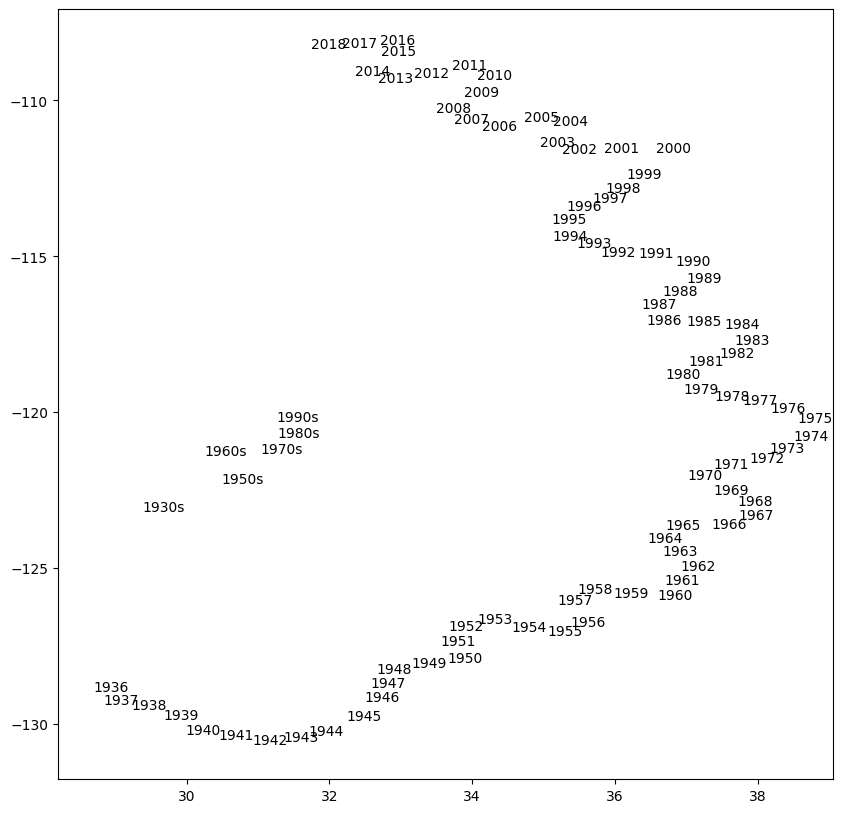

In [ ]:
# Plot the zoomed transformed BERT vocabulary embeddings:
# Define center vector between 0 and 1. E.g. [0,1] would mean bottom right and [0.5,0] would mean middle left
center = [0.7,0.1]
# Define a distance around the center vector
dist = 0.15
plot_zoom(center,dist)


There is a cluster of american places, with states on top and cities below and washington in betweeen. Even further away are places outside of the US but in english speaking countries like Australia and Great Britain.

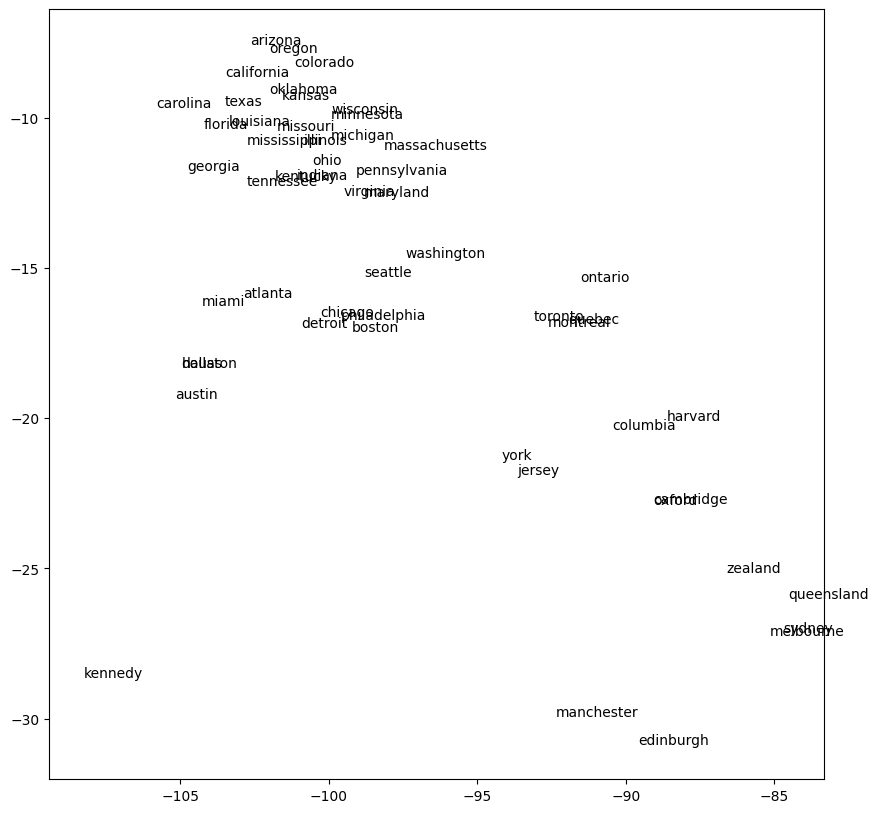

In [ ]:
plot_zoom([0.13,0.46],0.1)

If we continue in the direction of the non US places we find a cluster of countries and places, which are sorted by regions. Interestingly are south american states closer to spain and portugal, which makes sense due to the same language. Generally are countries with a shared border or a shared religion or language very near to each other as they must be used often in a similar context. E.g. Greece is next to turkey and turkey is next to arabic countries, which is close to Israel.

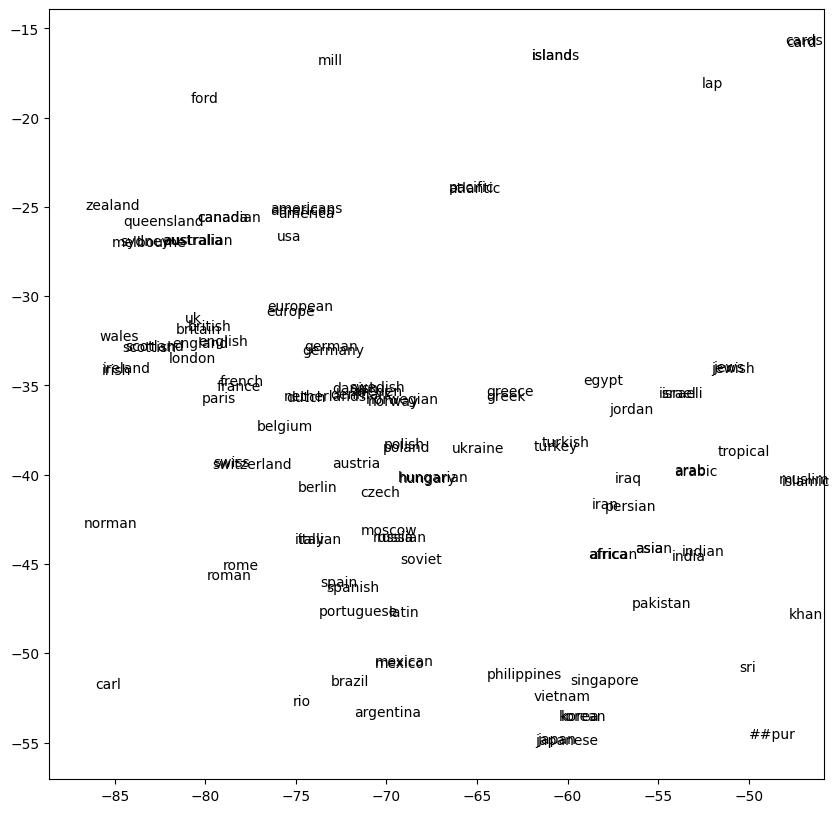

In [ ]:
plot_zoom([0.25,0.4],0.15)

Another cluster consists of names, wherein the names are clustered into first and family names with some names in betweeen, which can be both. Names of american presidents like kennedy or lincoln are close to the american places cluster.

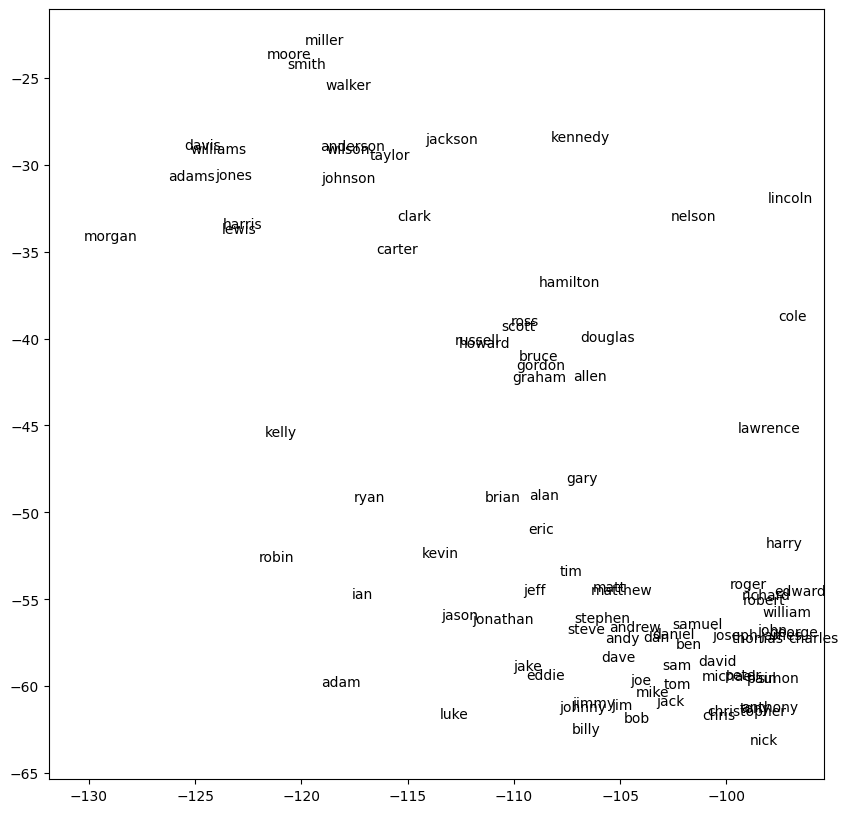

In [ ]:
plot_zoom([0.05,0.37],0.15)